In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
"""
Find how long a catchup period typically was

"""
import numpy as np

from ema import read

meal_df = read.raw_meal_info()

# Add a timestamp
meal_df["Datetime"] = read._datetime(meal_df)
meal_df.set_index("Datetime", inplace=True)


In [22]:
catchup = False
start_time = None
catchup_lengths = []
start_times = []
times_since_start = []
times_in_current_period = []

for time, entry in meal_df["meal_type"].items():
    # We're currently in a catchup period
    if catchup and entry not in {"Catch-up start", "Catch-up end"}:
        times_in_current_period.append((time - start_time).seconds)

    # New catchup period started
    if entry == "Catch-up start":
        catchup = True
        start_time = time
        times_in_current_period = []

    # We've hit the end of a catchup period
    elif entry == "Catch-up end":
        catchup_lengths.append((time - start_time).seconds)

        times_since_start.append(times_in_current_period)
        start_times.append(start_time.time())
        catchup = False

# We don't need this any more
del times_in_current_period

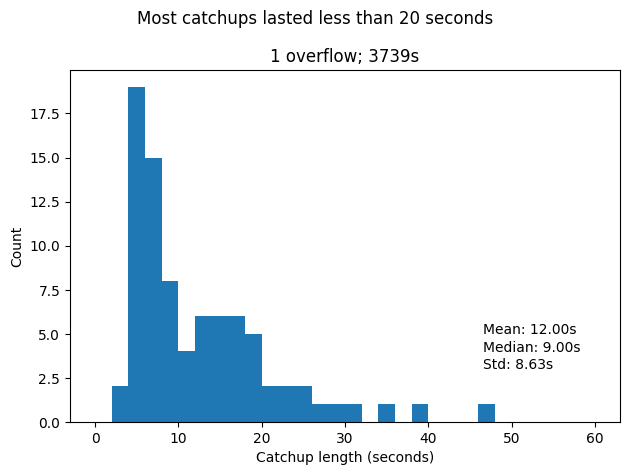

In [23]:
import matplotlib.pyplot as plt

bins = np.linspace(0, 60, 31)

fig, axis = plt.subplots()
count, bins, artists = axis.hist(catchup_lengths, bins=bins)

axis.set_xlabel("Catchup length (seconds)")
axis.set_ylabel("Count")
fig.suptitle("Most catchups lasted less than 20 seconds")

overflow_lens = [str(l) for l in catchup_lengths if l > bins[-1]]

axis.set_title(f"{len(overflow_lens)} overflow; {', '.join(overflow_lens)}s")

# Add some stats
x_pos, y_pos = 0.75, 0.25
times_in_plot = [l for l in catchup_lengths if l < bins[-1]]
axis.text(
    x_pos, y_pos, f"Mean: {np.mean(times_in_plot):.2f}s", transform=axis.transAxes
)
axis.text(
    x_pos,
    y_pos - 0.05,
    f"Median: {np.median(times_in_plot):.2f}s",
    transform=axis.transAxes,
)
axis.text(
    x_pos, y_pos - 0.1, f"Std: {np.std(times_in_plot):.2f}s", transform=axis.transAxes
)
fig.tight_layout()

fig.savefig("img/catchup_lengths.png", dpi=300)

3


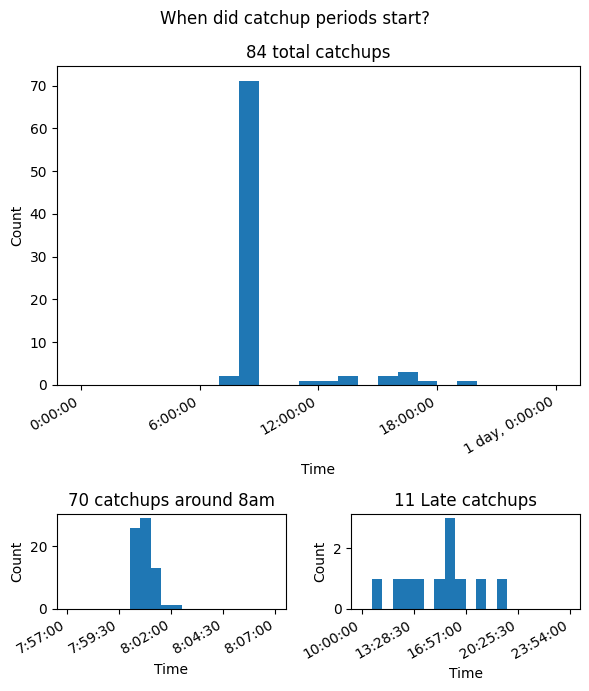

In [24]:
"""
When did they occur?

"""
import datetime

seconds_past_midnight = [
    time.hour * 3600 + time.minute * 60 + time.second for time in start_times
]


def hist(axis: plt.Axes, bins: np.ndarray, title_suffix: str):
    """
    Plot a histogram and set the title

    """
    counts, *_ = axis.hist(seconds_past_midnight, bins=bins)
    axis.set_title(f"{int(np.sum(counts))} {title_suffix}")

    ticks = np.linspace(bins[0], bins[-1], 5)
    axis.set_xticks(
        ticks,
        labels=[str(datetime.timedelta(seconds=time)) for time in ticks],
        rotation=30,
        ha="right",
    )

    return int(np.sum(counts))


fig, axes = plt.subplot_mosaic("AAAA\nAAAA\nBBCC", figsize=(6, 7))

# The whole period
all_bins = np.linspace(0, 24 * 3600, 25)
total = hist(axes["A"], all_bins, "total catchups")

# Around 8am
early_bins = 3600 * 8 + 60 * np.linspace(-3, 7, 21)
early = hist(axes["B"], early_bins, "catchups around 8am")

# Later in the afternoon/evening
late_bins = 3600 * 10 + 3600 * np.linspace(0, 13.9, 21)
late = hist(axes["C"], late_bins, "Late catchups")

fig.suptitle("When did catchup periods start?")

# There also may be some missing
print(total - (early + late))

for axis in axes.values():
    axis.set_xlabel("Time")
    axis.set_ylabel("Count")
# fig.autofmt_xdate()
fig.tight_layout()

fig.savefig("img/catchup_times.png", dpi=300)

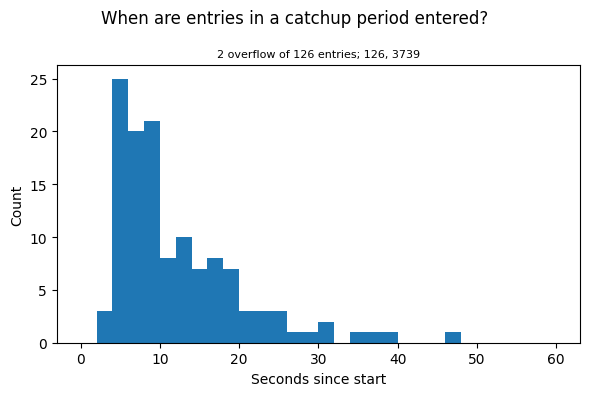

In [28]:
"""
For valid periods, how long do the entries after the start of the catchup period take?

"""
fig, axis = plt.subplots(figsize=(6, 4))

flattened_times = [a for l in times_since_start for a in l]
bins = np.linspace(0, 60, 31)

overflow_times = [str(l) for l in flattened_times if l > bins[-1]]


counts, *_ = axis.hist(
    flattened_times,
    bins=bins,
    label="Catchup period",
)

fig.suptitle("When are entries in a catchup period entered?")
axis.set_title(
    f"{len(overflow_times)} overflow of {int(np.sum(counts))} entries; {', '.join(overflow_times)}",
    fontsize=8,
)
axis.set_xlabel("Seconds since start")
axis.set_ylabel("Count")

fig.tight_layout()
fig.savefig("img/seconds_since_catchup.png")

In [26]:
"""
Quantify the different types of catchup, and how many of each there are

"""

'\nQuantify the different types of catchup, and how many of each there are\n\n'

In [27]:
"""
Now let's try to come up with some rules for dealing with the catchups

"""
# These ones are normal - there's a start and an end within 1 minute

# These ones are technically fine, but a bit unusual - the end is more than 10 minutes after the start

# These ones are quite unusual - the start was after 10am, but there's still an end

# These ones are clearly wrong - there's a start but no end
# Let's take all entries within 1 minute of this as being "catchup",
# and if there are none we'll just take the next entry

"\nNow let's try to come up with some rules for dealing with the catchups\n\n"